Nama              : Dwi Abriansya Alimuddin

No Registrasi FGA : 0182180121-127

# Submission Klasifikasi Multitext NLP Dicoding

## Upload dan Read Dataset

In [1]:
# Upload File Dataset
from google.colab import files
uploaded = files.upload()

Saving test.txt to test.txt
Saving train.txt to train.txt
Saving val.txt to val.txt


In [2]:
# Read File Dataset
import pandas as pd
train = pd.read_csv('train.txt', sep=';', names=['sentences', 'feelings'])
test = pd.read_csv('test.txt', sep=';', names=['sentences', 'feelings'])
val = pd.read_csv('val.txt', sep=';', names=['sentences', 'feelings'])

df = train.append(test)
df = df.append(val)
df.head()

,sentences,feelings
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Data Preprocessing

### Null dan Duplicated Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  20000 non-null  object
 1   feelings   20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


In [4]:
# Cek Data Null
df.isna().sum()

sentences    0
feelings     0
dtype: int64

In [5]:
# Cek Data Duplicated
df.duplicated().sum()

1

In [6]:
# Hilangkan Duplicated Data
df.drop_duplicates(inplace=True)

### Feature Engineering

In [7]:
# One-Hot Encoding Label
category = pd.get_dummies(df['feelings'])
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='feelings')
df_baru

,sentences,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,0,0,0,0,1,0
1996,i constantly worry about their fight against n...,0,0,1,0,0,0
1997,i feel its important to share this info for th...,0,0,1,0,0,0
1998,i truly feel that if you are passionate enough...,0,0,1,0,0,0


## Train Test Split

In [8]:
sinopsis = df_baru['sentences'].values
label = df_baru[['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']].values

In [9]:
# Train Test Split dengan Rasio Train 80% dan Test 20%
from sklearn.model_selection import train_test_split
sinopsis_latih, sinopsis_test, label_latih, label_test = train_test_split(sinopsis, label, test_size=0.2)

## Mencari Banyak Kata

In [10]:
# Inisiasi Fungsi Hitung Kata
from collections import Counter

def counter_words(text):
  count = Counter()
  for i in text.values:
    for word in i.split():
      count[word] += 1
  return count

In [11]:
# Menghitung Banyak Kata
sentence = df_baru['sentences']
counter = counter_words(sentence)
num_words = len(counter)
num_words

17096

## Tokenizer

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=num_words, oov_token='x')
tokenizer.fit_on_texts(sinopsis_latih) 
tokenizer.fit_on_texts(sinopsis_test)
 
sekuens_latih = tokenizer.texts_to_sequences(sinopsis_latih)
sekuens_test = tokenizer.texts_to_sequences(sinopsis_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

## Arsitektur Model

In [13]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Embedding dengan dimensi input sebanyak kata dan dimensi output 64
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=64),
    # LSTM dengan output 128 neuron
    tf.keras.layers.LSTM(128),        
    # Hidden layer dengan 64 neuron               
    tf.keras.layers.Dense(64, activation='relu'),
    # Dropout layer 0.5
    tf.keras.layers.Dropout(0.5),
    # Output layer, klasifikasi 6 class sehingga menggunakan aktivasi softmax
    tf.keras.layers.Dense(6, activation='softmax')])

model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

### Inisiasi Fungsi Callback

In [14]:
# Inisiasi fungsi callback dengan syarat akurasi 90%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_accuracy')>0.90) & (logs.get('accuracy')>0.90):
      print('\nAkurasi telah mencapai >90%!')
      self.model.stop_training = True

# Inisiasi class myCallback ke dalam variable callbacks
callbacks = myCallback()

## Training Model

In [16]:
# Training model
history = model.fit(
    padded_latih, label_latih,                  # Data Train
    epochs=30,                                  # Jumlah Epoch
    validation_data=(padded_test, label_test),  # Data Test
    callbacks=callbacks,                        # Memanggil Fungsi Callbacks
    verbose=1)                                  # Menampilkan Hasil Epoch

Epoch 1/30
500/500 [==============================] - 14s 12ms/step - loss: 1.3869 - accuracy: 0.4618 - val_loss: 0.9851 - val_accuracy: 0.6562
Epoch 2/30
500/500 [==============================] - 5s 11ms/step - loss: 0.6137 - accuracy: 0.7825 - val_loss: 0.4560 - val_accuracy: 0.8407
Epoch 3/30
500/500 [==============================] - 5s 11ms/step - loss: 0.3313 - accuracy: 0.8905 - val_loss: 0.3568 - val_accuracy: 0.8832
Epoch 4/30
500/500 [==============================] - 5s 11ms/step - loss: 0.2337 - accuracy: 0.9197 - val_loss: 0.2771 - val_accuracy: 0.9135

Akurasi telah mencapai >90%!


## Plot Loss dan Accuracy

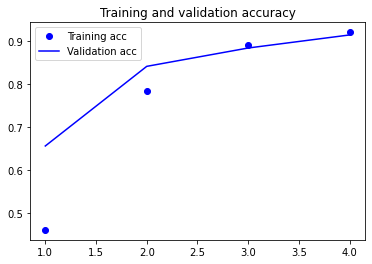

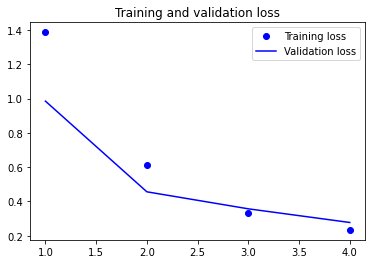

In [17]:
import matplotlib.pyplot as plt

# Ekstrak akurasi dan loss dari training model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot akurasi training dan validasi
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot loss training dan validasi
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()